<a href="https://colab.research.google.com/github/LAOLIVEIRA1972/PUC_MVP/blob/main/mvp_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# importações necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import mean_squared_error # métrica de avaliação MSE
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.tree import DecisionTreeRegressor # algoritmo Árvore de Regressão
from sklearn.svm import SVR # algoritmo SVM

# Informa a URL de importação do dataset (usando o link raw para o arquivo no GitHub)
url = "https://raw.githubusercontent.com/LAOLIVEIRA1972/PUC_MVP/main/dataset_plataformas.xlsx"

# Lê o arquivo
dataset = pd.read_excel(url)

# Mostra as primeiras linhas do dataset
display(dataset.head())

# transforma atributos categóricos em numéricos
cols_cat = ["PLATAFORMA", "TIPO", "PROPRIEDADE","LDA", "BACIA", "RESTRICAO_QUEIMA", "TIPO_OPERACAO"]
for col in cols_cat:
    dataset[col] = dataset[col].replace({sorted(dataset[col].unique())[i]:i for i in range(len(sorted(dataset[col].unique())))})

# Mostra as primeiras linhas do dataset
display(dataset.head())

,PLATAFORMA,TIPO,PROPRIEDADE,LDA,BACIA,RESTRICAO_QUEIMA,TIPO_OPERACAO,IDADE_NA _PARADA,DURAÇÃO
0,PA04,FPSO,Afretado,P,B1,NÃO,Produção,3,9.0
1,PA05,FPSO,Afretado,P,B1,NÃO,Produção,3,14.0
2,PA05,FPSO,Afretado,P,B1,NÃO,Injeção,3,13.0
3,PA09,FPSO,Afretado,P,B1,NÃO,Produção,4,14.0
4,PA09,FPSO,Afretado,P,B1,NÃO,Produção,6,25.0


,PLATAFORMA,TIPO,PROPRIEDADE,LDA,BACIA,RESTRICAO_QUEIMA,TIPO_OPERACAO,IDADE_NA _PARADA,DURAÇÃO
0,3,1,0,0,0,0,1,3,9.0
1,4,1,0,0,0,0,1,3,14.0
2,4,1,0,0,0,0,0,3,13.0
3,8,1,0,0,0,0,1,4,14.0
4,8,1,0,0,0,0,1,6,25.0


In [12]:
# Preparação dos dados

# Separação em bases de treino e teste (holdout)
array = dataset.values
X = array[:,0:8] # atributos
y = array[:,8] # classe (target)

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão em bases de treino e teste

# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

LR: MSE 749.32 (820.44) - RMSE 27.37
Ridge: MSE 747.52 (819.00) - RMSE 27.34
Lasso: MSE 729.25 (812.70) - RMSE 27.00
KNN: MSE 750.77 (801.48) - RMSE 27.40
CART: MSE 932.13 (799.68) - RMSE 30.53
SVM: MSE 781.37 (831.26) - RMSE 27.95


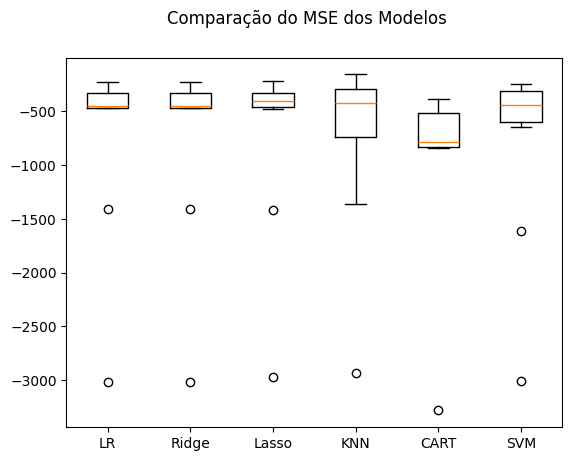

In [16]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(7)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
modelos = []
resultados = []
nomes = []

# Preparando os modelos e adicionando-os em uma lista
modelos.append(('LR', LinearRegression()))
modelos.append(('Ridge', Ridge()))
modelos.append(('Lasso', Lasso()))
modelos.append(('KNN', KNeighborsRegressor()))
modelos.append(('CART', DecisionTreeRegressor()))
modelos.append(('SVM', SVR()))

# Avaliando um modelo por vez
for nome, modelo in modelos:
  cv_resultados = cross_val_score(modelo, X_treino, y_treino, cv=kfold, scoring='neg_mean_squared_error')
  resultados.append(cv_resultados)
  nomes.append(nome)
  # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (nome, abs(cv_resultados.mean()), cv_resultados.std(), np.sqrt(abs(cv_resultados.mean())))
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

In [14]:
# Criando um modelo com todo o conjunto de treino
modelo = Lasso()
modelo.fit(X_treino, y_treino)

# Fazendo as predições com o conjunto de teste
predicoes = modelo.predict(X_teste)

# Estimando o MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_teste, predicoes)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

MSE 492.72
RMSE 22.20
